In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt
from SNN_JHK_v3_230314 import *
from Function.Stimulation import *
from Function.ReceptiveField import *
import torch.nn as nn
from Function.plot_SNN import *
import torch
import torch.nn as nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
print("GPU available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


GPU available: False
CUDA version: None


In [24]:
# on mac
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.0.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-10.16-x86_64-i386-64bit


In [25]:
sensor_h, sensor_w = 19, 16 #(mm)
pixel_h, pixel_w = 64, 48
img_FPS = 60

In [26]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_left2right = np.zeros((pixel_h, pixel_w, num_stim))

F = 10
for i in range(num_stim):
    x0 = i * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/16
    stim_dot = dot_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w,r=2)
    stimulation_left2right[:, :, i] = stim_dot
    # if i % 200 == 0:
    #     plt.imshow(stimulation_left2right[:, :, i], cmap='jet')
    #     plt.show()


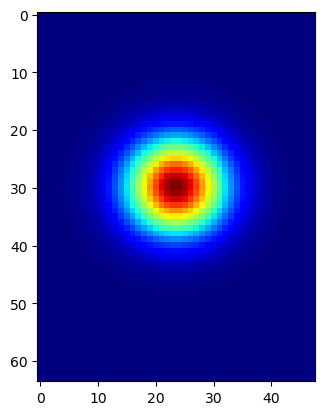

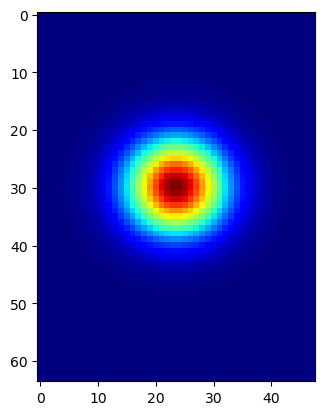

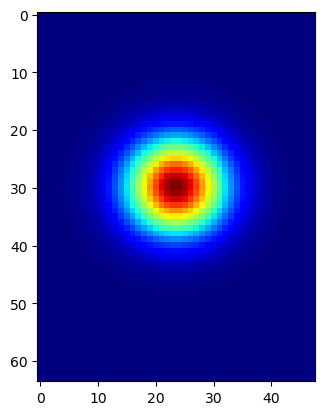

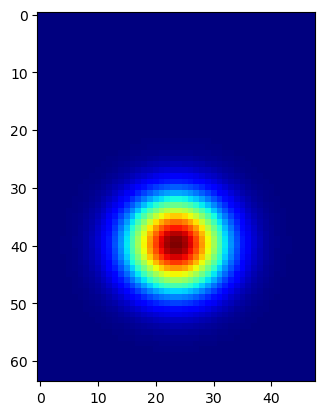

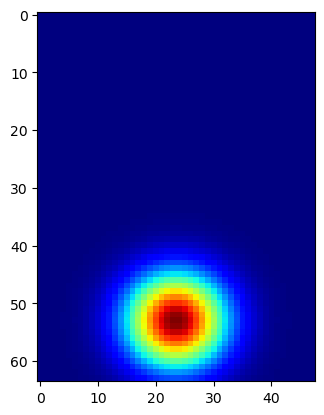

In [27]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_drop = np.zeros((pixel_h, pixel_w, num_stim))

F = 20
for i in range(num_stim):
    if i < 500:
        x0 = 8  # Move the stimulus by 0.3mm for each frame
        y0 = 9
    else:
        x0 = 8
        y0 = i*0.3/15
    stim_dot = dot_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w,r=2)
    stimulation_drop[:, :, i] = stim_dot
    if i % 200 == 0:
        plt.imshow(stimulation_drop[:, :, i], cmap='jet')
        plt.show()

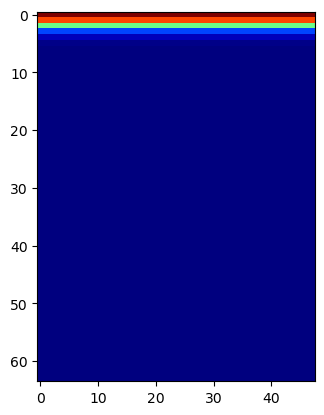

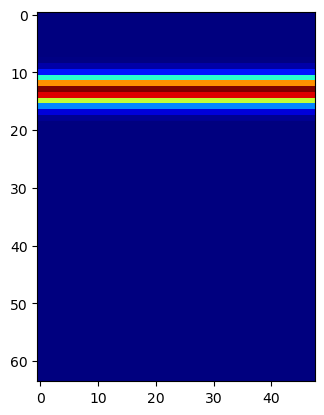

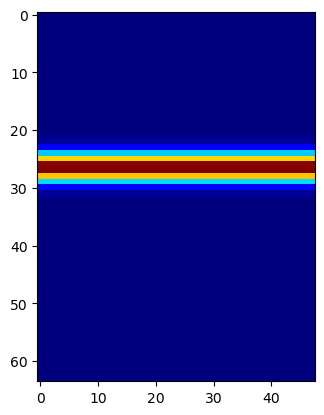

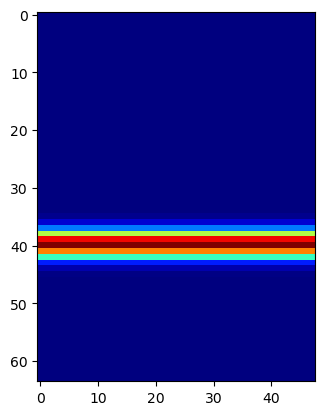

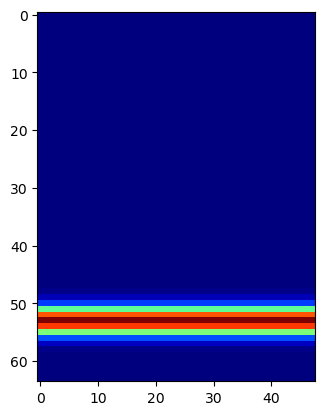

In [28]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_0 = np.zeros((pixel_h, pixel_w, num_stim))

F = 10
for i in range(num_stim):
    x0 = i * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w, w=0.5)
    stimulation_angle_0[:, :, i] = stim_dot
    if i % 200 == 0:
        plt.imshow(stimulation_angle_0[:, :, i], cmap='jet')
      
        plt.show()
        


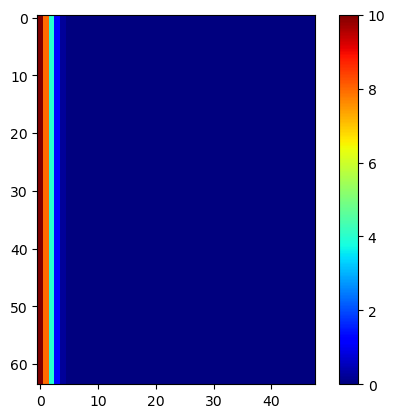

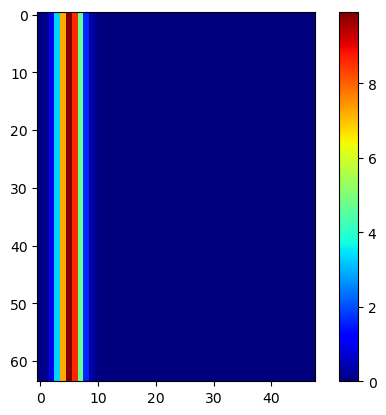

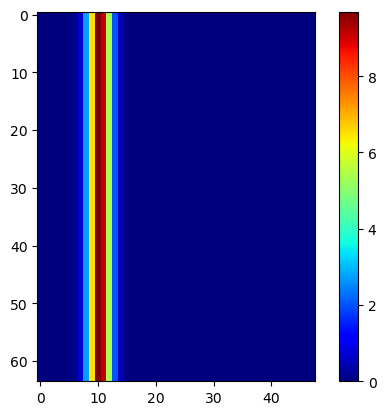

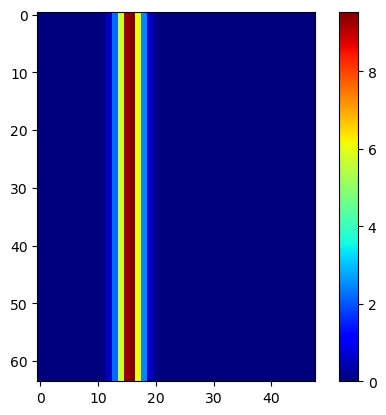

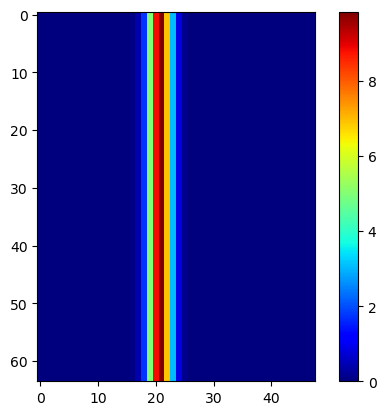

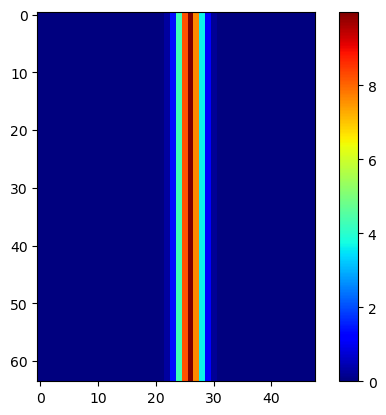

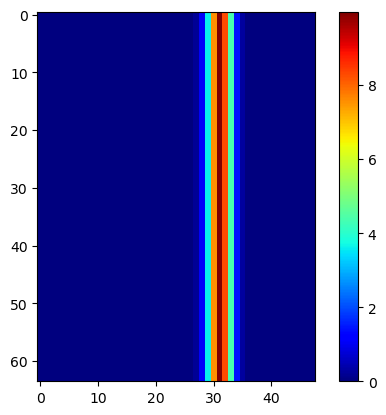

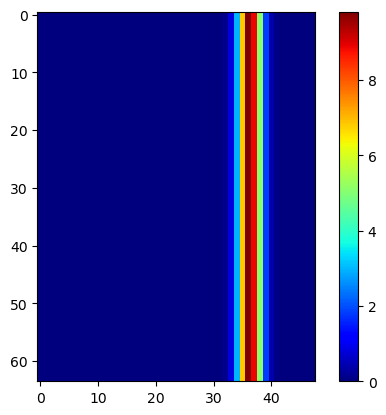

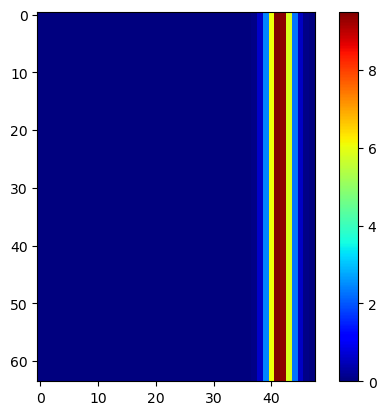

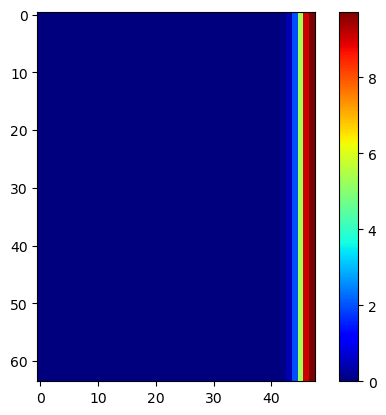

In [29]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_90 = np.zeros((pixel_h, pixel_w, num_stim))

F = 10
for i in range(num_stim):
    x0 = i * 0.3/17  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w,theta=np.pi/2,w=0.5)
    stimulation_angle_90[:, :, i] = stim_dot
    if i % 100 == 0:
        plt.imshow(stimulation_angle_90[:, :, i], cmap='jet')
        plt.colorbar()
        plt.show()

/var/folders/q5/dzpd5sxn6q34c2zg732hqhj00000gn/T/ipykernel_68054/1537080979.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


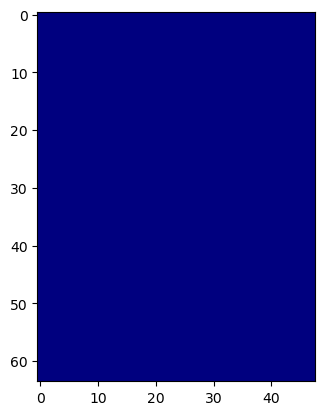

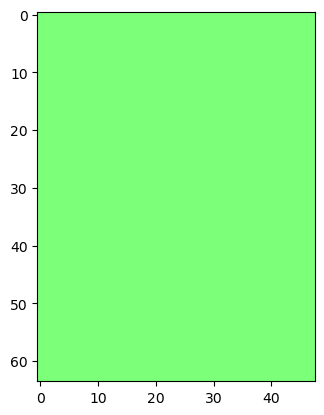

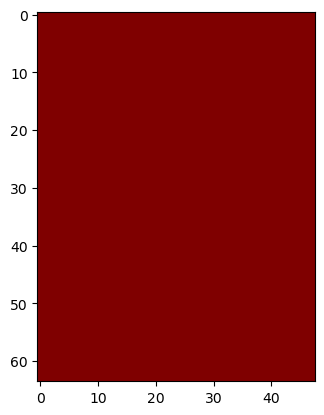

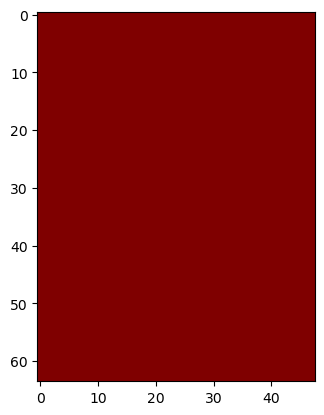

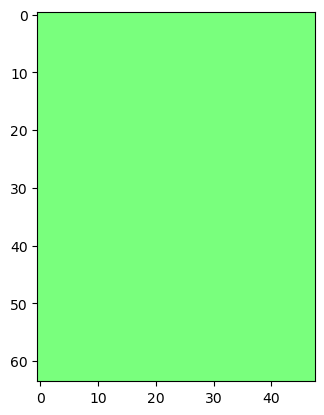

In [30]:
num_stim = 1000

# Generate the sequence of F values
max_F = 10
F_array = np.concatenate([
    np.zeros((100,)),
    np.linspace(0, max_F, 200),
    np.full((400,), max_F),
    np.linspace(max_F, 0, 200),
    np.zeros((100,))
])

# Preallocate the stimulation_full array
stimulation_full = np.zeros((pixel_h, pixel_w, num_stim))

# Create a color map with a range of 0 to max_F
cmap = plt.cm.get_cmap('jet')
cmap.set_under('k')

# Iterate over F_array and generate the stimuli
for i, F_i in enumerate(F_array):
    stim_dot = full_stim(F=F_i, pixel_h=pixel_h, pixel_w=pixel_w)
    stimulation_full[:, :, i] = stim_dot
    if i % 200 == 0:
        plt.imshow(stimulation_full[:, :, i], cmap=cmap, vmin=0, vmax=max_F)
        
        plt.show()
        


In [31]:
rf_SA_array = generate_receptivefield()
print(rf_SA_array.shape)
rf_RA_array = generate_receptivefield(kernel_w=15,kernel_h=15)

receptive_field = [np.array([[1,-0.5],[1,-0.5],[1,-0.5],[1,-0.5],[1,-0.5]]),
                   np.array([[1,1,1,1,1],[-0.5,-0.5,-0.5,-0.5,-0.5]]),
                   10*np.ones((7,7))]

receptive_field_noninit = [np.array([[6],[6],[6],[6],[6]]),
                   np.array([[6,6,6,6,6]]),
                   10*np.ones((7,7))]

time_delay = [np.array([[5,1],[5,1],[5,1],[5,1],[5,1]]),np.array([[5,5,5,5,5],[1,1,1,1,1]])]

rf_SA_array_2,rf_SA_length = generate_receptivefield_2(receptive_field,pixel_h=10,
                                                       pixel_w=7,step_size=1)

rf_RA_array_2,rf_RA_length = generate_receptivefield_2(receptive_field,pixel_h=9,
                                                       pixel_w=6,step_size=1)

time_delay_SA = generate_receptivefield_2(time_delay,pixel_h=10,pixel_w=7,step_size=1)



10 7
Complete! Created 10x10 kernel with step size 6! Generated 70 times.
(70, 3072)
9 6
Complete! Created 15x15 kernel with step size 6! Generated 54 times.
6 6
9 3
4 1
Complete! Generated 67 receptive fields.
5 5
8 2
3 0
Complete! Generated 41 receptive fields.
6 6
9 3
Complete! Generated 63 receptive fields.


layer initialized
layer initialized
layer initialized
layer initialized
0.6826870441436768
[ 995. 1040.  655.  365.   50.    0.    0.    0.    0.    0.  990. 1220.
 1070.  750.  505.  130.    0.    0.    0.    0.  585. 1065. 1205. 1085.
  650.  495.  150.    0.    0.    0.   85.  500. 1015. 1235. 1200.  800.
  465.  120.    5.    0.    0.  125.  365.  960. 1195. 1280. 1165.  530.
  215.    0.    0.    0.  150.  400.  635. 1150. 1180. 1145.  515.  220.
    0.    0.    0.   15.  360.  655. 1110. 1205. 1160.  615.]
[270. 255. 170.  35.   0.   0.   0.   0.   0. 225. 285. 280. 160.  50.
   0.   0.   0.   0. 110. 220. 340. 255. 170.  70.   0.   0.   0.   0.
  30. 205. 360. 330. 180.  30.   0.   0.   0.   0.  35. 135. 180. 245.
 190.  35.   0.   0.   0.   0.  35. 185. 215. 300. 260.  50.]


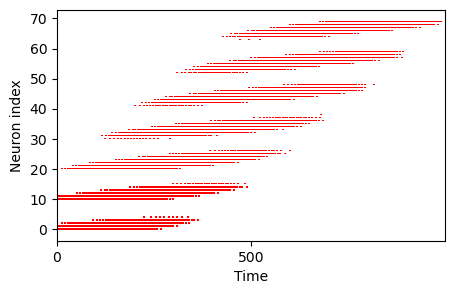

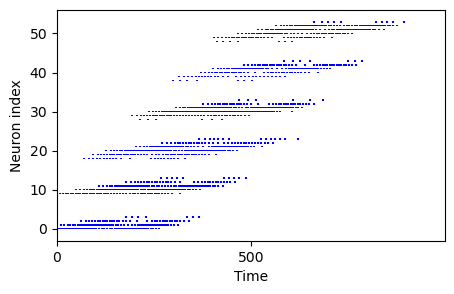

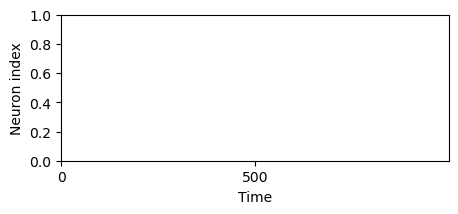

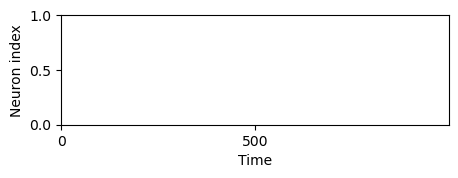

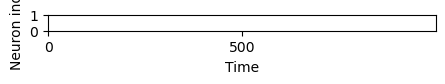

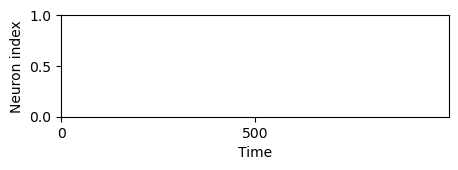

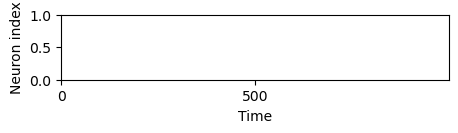

In [32]:
stim = stimulation_left2right

input_SA_receptiveField = Synapse(rf_SA_array)
input_RA_receptiveField = Synapse(rf_RA_array)

input_SA_receptiveField_2 = Synapse(rf_SA_array_2)
input_RA_receptiveField_2 = Synapse(rf_RA_array_2)

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_SA_array),a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_RA_array),a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_RA_array_2),a_decay=1)

L1_SA_spike_times = np.zeros((len(rf_SA_array), num_stim-1))
L1_RA_spike_times = np.zeros((len(rf_RA_array), num_stim-1))
L2_SA_spike_times = np.zeros((len(rf_SA_array_2), num_stim-1))
L2_RA_spike_times = np.zeros((len(rf_RA_array_2), num_stim-1))

start_time = time.time()

for i in range(1,num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].reshape(-1))*2
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        np.abs(stim[:, :, i] - stim[:, :, i - 1]).reshape(-1))*20
    
    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)
    
    
    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

print
end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(np.sum(L1_SA_spike_times,axis=1)/0.2)
print(np.sum(L1_RA_spike_times,axis=1)/0.2)
plot_spike_times(L1_SA_spike_times,'r',size = (5,3))
plot_spike_times(L1_RA_spike_times,'b')
plot_spike_times(L2_SA_spike_times[0:36],'orange',size = (5,3*36/57))
plot_spike_times(L2_SA_spike_times[36:53],'orange',size = (5,3*27/57))
plot_spike_times(L2_SA_spike_times[53:57],'orange',size = (5,3*4/57))
plot_spike_times(L2_RA_spike_times[0:25],'g',size = (5,3*25/57))
plot_spike_times(L2_RA_spike_times[25:41],'g',size = (5,3*16/57))

layer initialized
layer initialized
layer initialized
layer initialized
0.46490979194641113
[ 995. 1040.  655.  365.   50.    0.    0.    0.    0.    0.  990. 1220.
 1070.  750.  505.  130.    0.    0.    0.    0.  585. 1065. 1205. 1085.
  650.  495.  150.    0.    0.    0.   85.  500. 1015. 1235. 1200.  800.
  465.  120.    5.    0.    0.  125.  365.  960. 1195. 1280. 1165.  530.
  215.    0.    0.    0.  150.  400.  635. 1150. 1180. 1145.  515.  220.
    0.    0.    0.   15.  360.  655. 1110. 1205. 1160.  615.]
[730. 835. 745. 395.  10.   0.   0.   0.   0. 810. 915. 895. 740. 430.
  30.   0.   0.   0. 570. 865. 935. 870. 780. 505. 170.   0.   0. 205.
 390. 865. 960. 915. 750. 425. 140.   0.   0.   5. 415. 620. 775. 860.
 785. 465. 220.   0.   0.  30. 390. 770. 855. 885. 885. 490.]


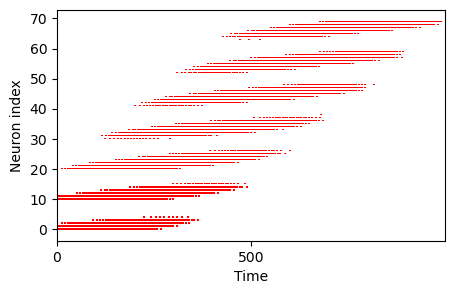

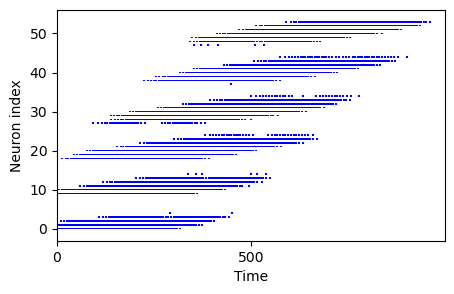

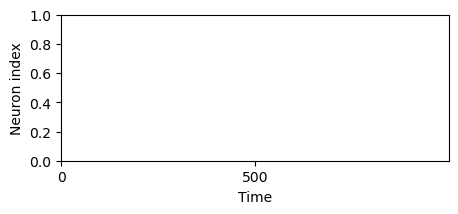

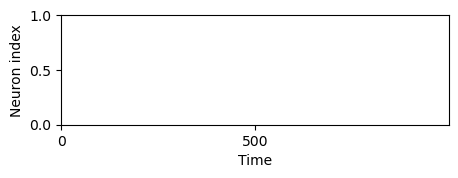

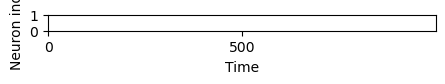

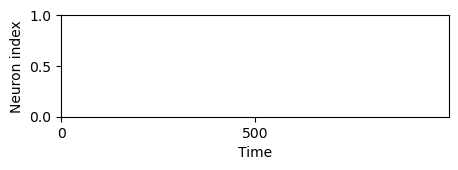

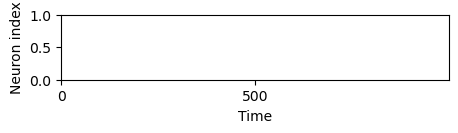

In [33]:
stim = stimulation_left2right

input_SA_receptiveField = Synapse(rf_SA_array)
input_RA_receptiveField = Synapse(rf_RA_array)

input_SA_receptiveField_2 = Synapse(rf_SA_array_2)
input_RA_receptiveField_2 = Synapse(rf_RA_array_2)

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_SA_array),a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_RA_array),a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_RA_array_2),a_decay=1)

L1_SA_spike_times = np.zeros((len(rf_SA_array), num_stim-1))
L1_RA_spike_times = np.zeros((len(rf_RA_array), num_stim-1))
L2_SA_spike_times = np.zeros((len(rf_SA_array_2), num_stim-1))
L2_RA_spike_times = np.zeros((len(rf_RA_array_2), num_stim-1))

start_time = time.time()

for i in range(1,num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].reshape(-1))*2
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        np.abs(stim[:, :, i] - stim[:, :, i - 1]).reshape(-1))*100
    
    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)
    
    
    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

print
end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(np.sum(L1_SA_spike_times,axis=1)/0.2)
print(np.sum(L1_RA_spike_times,axis=1)/0.2)
plot_spike_times(L1_SA_spike_times, 'r', size=(5, 3))
plot_spike_times(L1_RA_spike_times, 'b')
plot_spike_times(L2_SA_spike_times[0:36], 'orange', size=(5, 3*36/57))
plot_spike_times(L2_SA_spike_times[36:53], 'orange', size=(5, 3*27/57))
plot_spike_times(L2_SA_spike_times[53:57], 'orange', size=(5, 3*4/57))
plot_spike_times(L2_RA_spike_times[0:25], 'g', size=(5, 3*25/57))
plot_spike_times(L2_RA_spike_times[25:41], 'g', size=(5, 3*16/57))


layer initialized
layer initialized
layer initialized
layer initialized
0.40613293647766113
[685. 660. 790. 725. 680. 770. 755. 745. 655. 705. 645. 755. 695. 745.
 790. 755. 715. 695. 675. 695. 715. 740. 720. 715. 665. 730. 760. 605.
 635. 765. 575. 660. 755. 820. 720. 685. 680. 650. 680. 730. 660. 710.
 650. 815. 735. 760. 760. 650. 620. 700. 680. 705. 725. 810. 655. 690.
 685. 755. 705. 730. 710. 740. 600. 665. 680. 685. 740. 675. 720. 695.]
[570. 600. 735. 670. 600. 685. 430. 475. 650. 615. 585. 640. 730. 750.
 560. 655. 685. 575. 715. 725. 755. 595. 560. 705. 625. 665. 715. 730.
 540. 655. 755. 705. 600. 670. 725. 670. 460. 640. 690. 525. 465. 495.
 675. 530. 770. 565. 665. 530. 605. 700. 545. 640. 690. 610.]


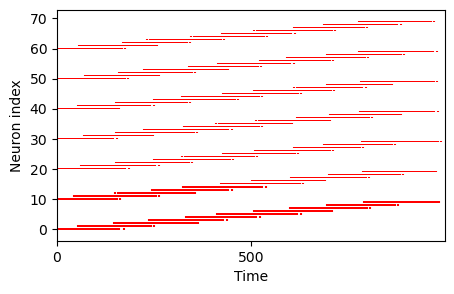

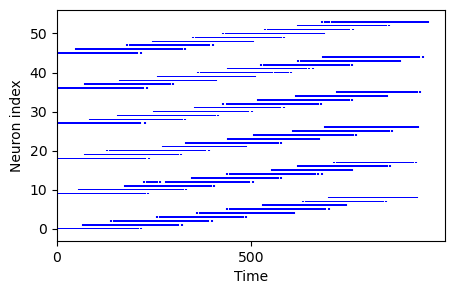

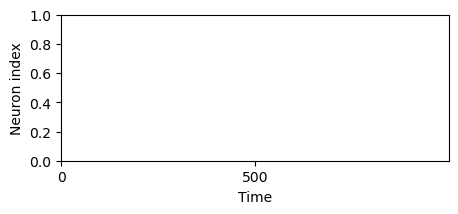

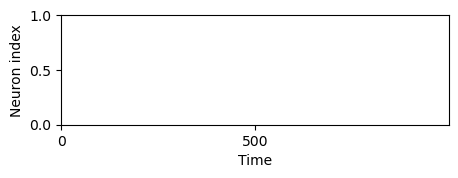

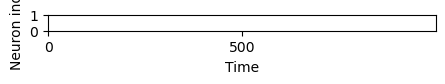

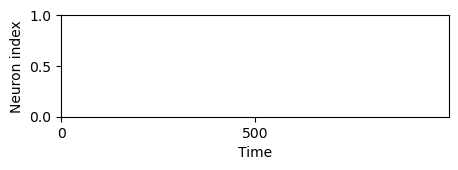

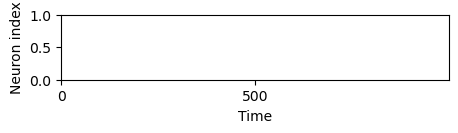

In [34]:
stim = stimulation_angle_0

input_SA_receptiveField = Synapse(rf_SA_array)
input_RA_receptiveField = Synapse(rf_RA_array)

input_SA_receptiveField_2 = Synapse(rf_SA_array_2)
input_RA_receptiveField_2 = Synapse(rf_RA_array_2)

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_SA_array), a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array), a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array_2), a_decay=1)

L1_SA_spike_times = np.zeros((len(rf_SA_array), num_stim-1))
L1_RA_spike_times = np.zeros((len(rf_RA_array), num_stim-1))
L2_SA_spike_times = np.zeros((len(rf_SA_array_2), num_stim-1))
L2_RA_spike_times = np.zeros((len(rf_RA_array_2), num_stim-1))

start_time = time.time()

for i in range(1, num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].reshape(-1))*4
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        np.abs(stim[:, :, i] - stim[:, :, i - 1]).reshape(-1))*60

    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)

    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

print
end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(np.sum(L1_SA_spike_times, axis=1)/0.2)
print(np.sum(L1_RA_spike_times, axis=1)/0.2)
plot_spike_times(L1_SA_spike_times,'r',size = (5,3))
plot_spike_times(L1_RA_spike_times,'b')
plot_spike_times(L2_SA_spike_times[0:36],'orange',size = (5,3*36/57))
plot_spike_times(L2_SA_spike_times[36:53],'orange',size = (5,3*27/57))
plot_spike_times(L2_SA_spike_times[53:57],'orange',size = (5,3*4/57))
plot_spike_times(L2_RA_spike_times[0:25],'g',size = (5,3*25/57))
plot_spike_times(L2_RA_spike_times[25:41],'g',size = (5,3*16/57))

layer initialized
layer initialized
layer initialized
layer initialized
0.4646110534667969
[ 830.  720.  760.  780.  830.  755.  850.  735.  805.  795.  930.  840.
  785.  850.  960.  805.  880.  785.  785.  955.  810.  935.  815.  870.
  850.  960.  930.  680.  740.  905.  830.  820.  825.  875.  820.  735.
  765.  690.  985.  865.  875.  855.  810.  885.  920.  895.  925.  870.
  900.  885.  860.  840. 1015.  835.  795.  935.  885.  870.  800.  795.
  895.  895.  710.  755.  880.  875.  930.  855.  900.  885.]
[ 985.  920. 1020.  940.  960.  995.  585.  820.  975. 1050.  975.  950.
 1015. 1070.  970.  950. 1085.  965. 1070. 1105. 1055. 1075.  945. 1080.
 1055.  985. 1125. 1095.  830.  960. 1080. 1120. 1055. 1030. 1050.  970.
  815.  975.  955.  895.  785.  930. 1080.  845. 1155.  920. 1035.  930.
 1025. 1075.  900.  960. 1040.  980.]


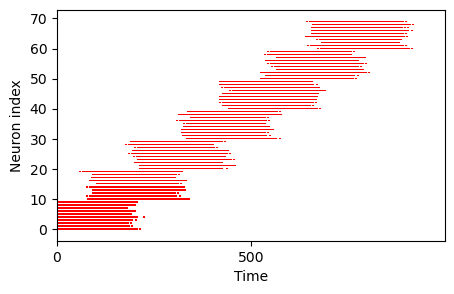

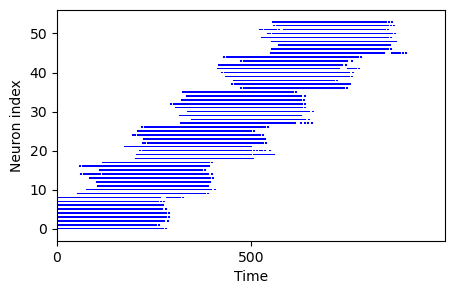

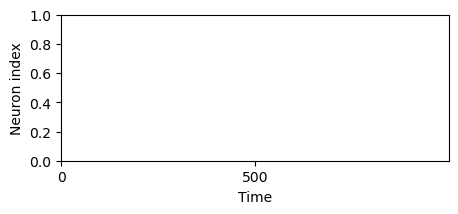

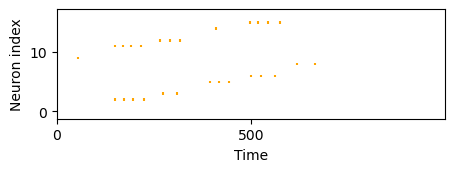

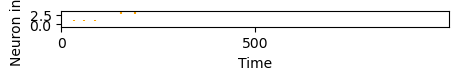

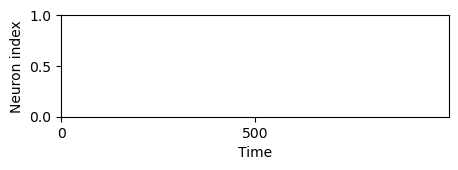

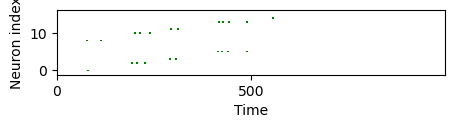

In [35]:
stim = stimulation_angle_90

input_SA_receptiveField = Synapse(rf_SA_array)
input_RA_receptiveField = Synapse(rf_RA_array)

input_SA_receptiveField_2 = Synapse(rf_SA_array_2)

input_RA_receptiveField_2 = Synapse(rf_RA_array_2)

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_SA_array), a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array), a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array_2), a_decay=1)

L1_SA_spike_times = np.zeros((len(rf_SA_array), num_stim-1))
L1_RA_spike_times = np.zeros((len(rf_RA_array), num_stim-1))
L2_SA_spike_times = np.zeros((len(rf_SA_array_2), num_stim-1))
L2_RA_spike_times = np.zeros((len(rf_RA_array_2), num_stim-1))

start_time = time.time()

for i in range(1, num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].reshape(-1))*4
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        np.abs(stim[:, :, i] - stim[:, :, i - 1]).reshape(-1))*100

    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)

    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

print
end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(np.sum(L1_SA_spike_times, axis=1)/0.2)
print(np.sum(L1_RA_spike_times, axis=1)/0.2)
plot_spike_times(L1_SA_spike_times,'r',size = (5,3))
plot_spike_times(L1_RA_spike_times,'b')
plot_spike_times(L2_SA_spike_times[0:36],'orange',size = (5,3*36/57))
plot_spike_times(L2_SA_spike_times[36:53],'orange',size = (5,3*27/57))
plot_spike_times(L2_SA_spike_times[53:57],'orange',size = (5,3*4/57))
plot_spike_times(L2_RA_spike_times[0:25],'g',size = (5,3*25/57))
plot_spike_times(L2_RA_spike_times[25:41],'g',size = (5,3*16/57))

layer initialized
layer initialized
layer initialized
layer initialized
0.4046788215637207
[3450. 3380. 3525. 3520. 3430. 3470. 3540. 3490. 3440. 3400. 3475. 3450.
 3370. 3470. 3580. 3500. 3515. 3400. 3370. 3440. 3540. 3560. 3440. 3355.
 3355. 3565. 3500. 3135. 3245. 3520. 3340. 3410. 3470. 3510. 3440. 3365.
 3355. 3285. 3440. 3490. 3560. 3530. 3355. 3480. 3450. 3520. 3540. 3380.
 3460. 3455. 3430. 3530. 3530. 3520. 3320. 3460. 3415. 3480. 3440. 3480.
 3490. 3490. 3275. 3300. 3420. 3500. 3430. 3440. 3490. 3450.]
[1000. 1000. 1000. 1000. 1000. 1000.  860. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.]


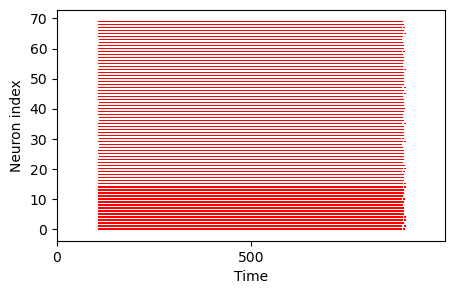

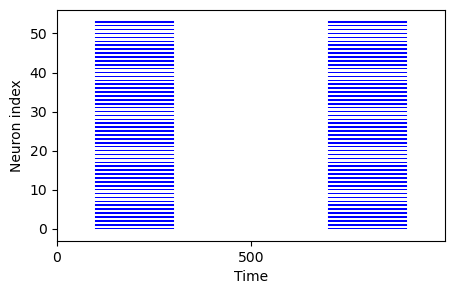

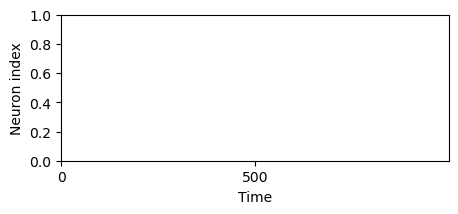

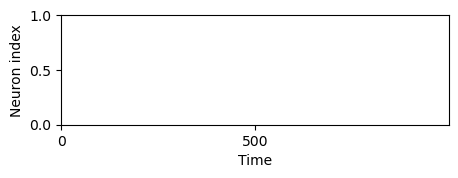

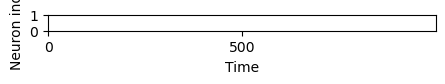

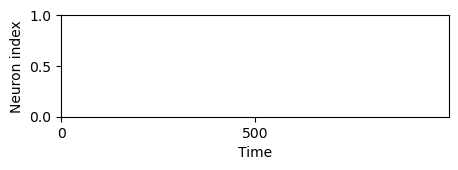

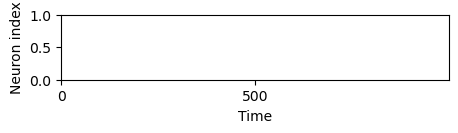

In [36]:
stim = stimulation_full

input_SA_receptiveField = Synapse(rf_SA_array)
input_RA_receptiveField = Synapse(rf_RA_array)

input_SA_receptiveField_2 = Synapse(rf_SA_array_2)
input_RA_receptiveField_2 = Synapse(rf_RA_array_2)

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_SA_array), a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array), a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array_2), a_decay=1)

L1_SA_spike_times = np.zeros((len(rf_SA_array), num_stim-1))
L1_RA_spike_times = np.zeros((len(rf_RA_array), num_stim-1))
L2_SA_spike_times = np.zeros((len(rf_SA_array_2), num_stim-1))
L2_RA_spike_times = np.zeros((len(rf_RA_array_2), num_stim-1))

start_time = time.time()

for i in range(1, num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].reshape(-1))*2
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        np.abs(stim[:, :, i] - stim[:, :, i - 1]).reshape(-1))*100

    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)

    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

print
end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(np.sum(L1_SA_spike_times, axis=1)/0.2)
print(np.sum(L1_RA_spike_times, axis=1)/0.2)
plot_spike_times(L1_SA_spike_times,'r',size = (5,3))
plot_spike_times(L1_RA_spike_times,'b')
plot_spike_times(L2_SA_spike_times[0:36],'orange',size = (5,3*36/57))
plot_spike_times(L2_SA_spike_times[36:53],'orange',size = (5,3*27/57))
plot_spike_times(L2_SA_spike_times[53:57],'orange',size = (5,3*4/57))
plot_spike_times(L2_RA_spike_times[0:25],'g',size = (5,3*25/57))
plot_spike_times(L2_RA_spike_times[25:41],'g',size = (5,3*16/57))


In [37]:
receptive_field = [np.array([[5,-2],[5,-2],[5,-2],[5,-2],[5,-2]]),np.array([[5,5,5,5,5],[-2,-2,-2,-2,-2]])]

receptive_field_time_delay = [np.array([[5, 1], [5, 1], [5, 1], [5, 1], [5, 1]]),
                   np.array([[5, 5, 5, 5, 5], [1,1,1,1,1]])]

rf_SA_array_2_time_delay = generate_receptivefield_2(
    receptive_field_time_delay, pixel_h=10, pixel_w=7, step_size=1)




6 6
9 3
Complete! Generated 63 receptive fields.


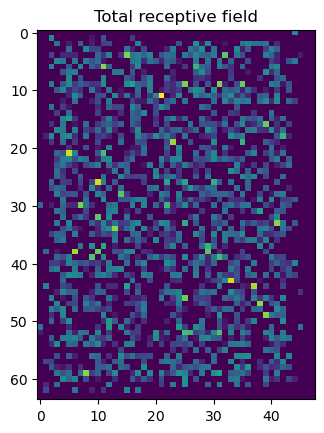

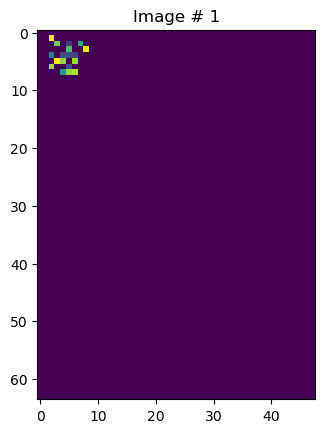

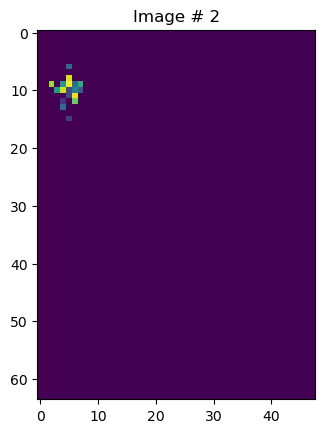

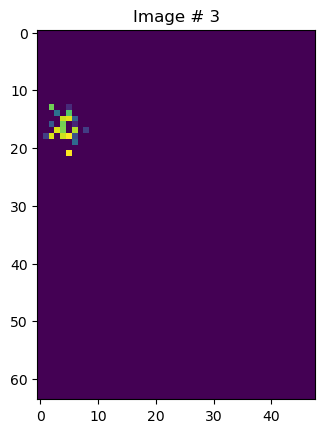

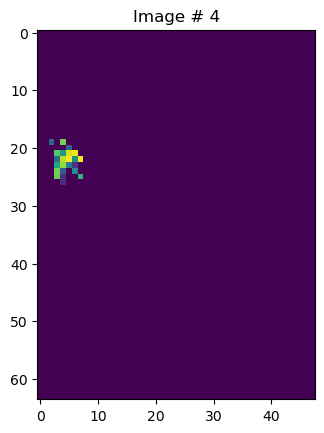

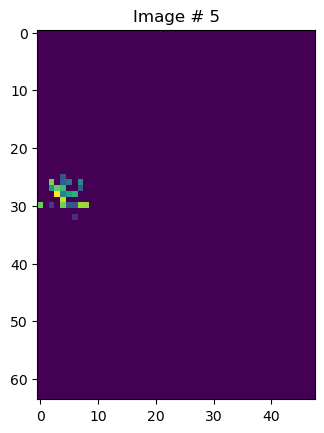

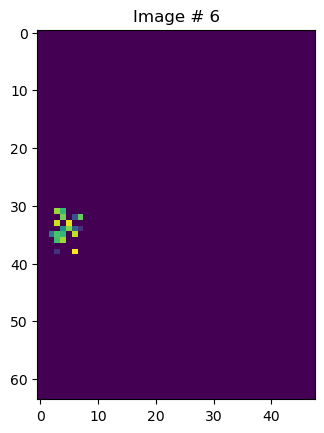

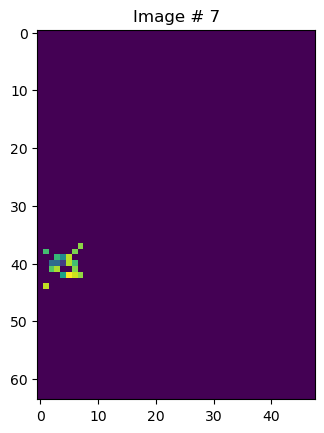

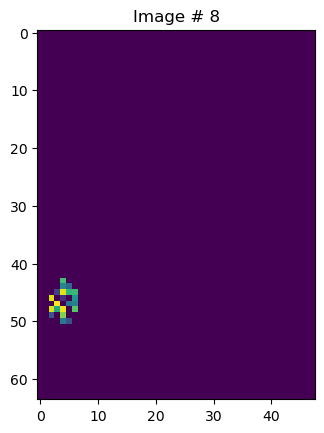

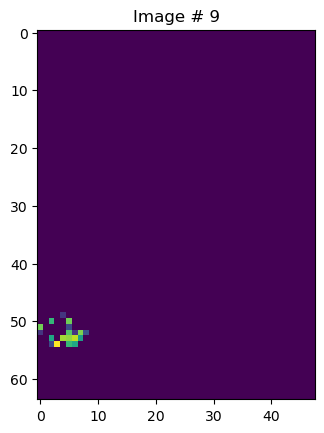

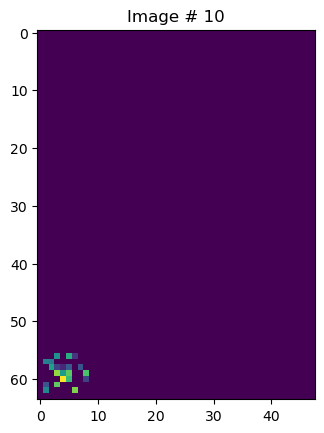

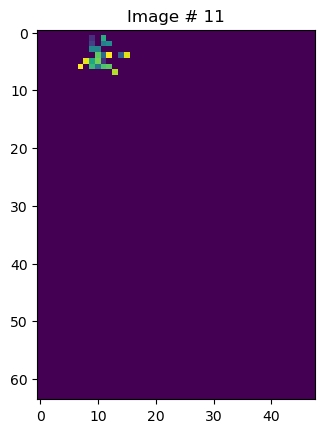

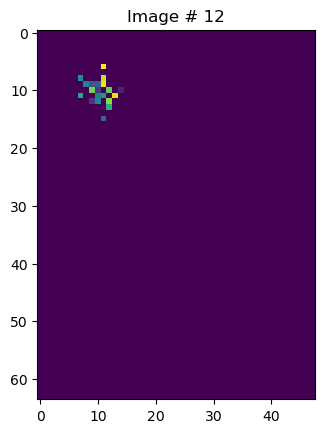

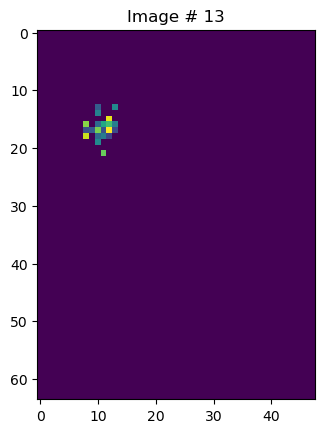

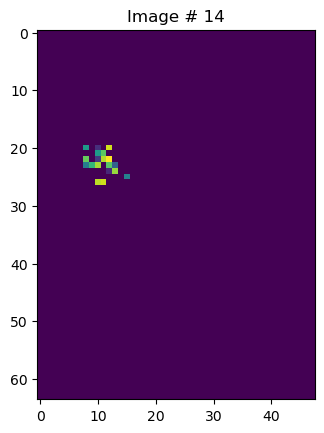

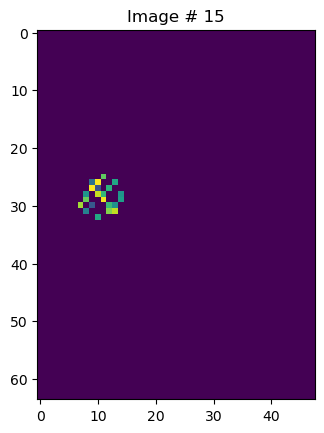

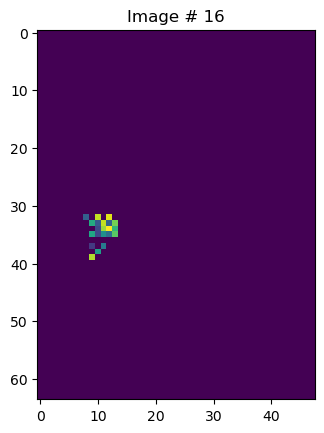

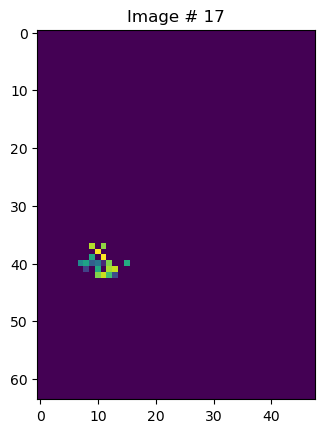

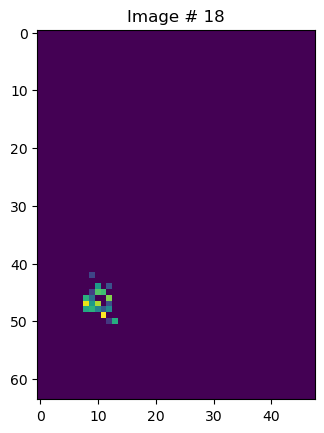

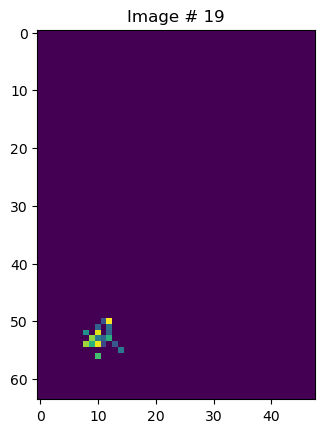

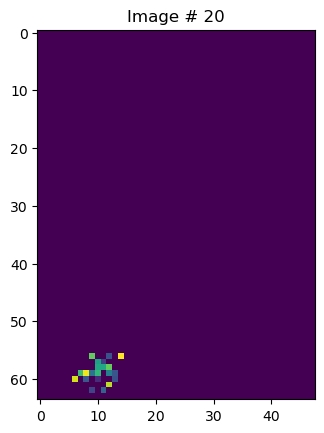

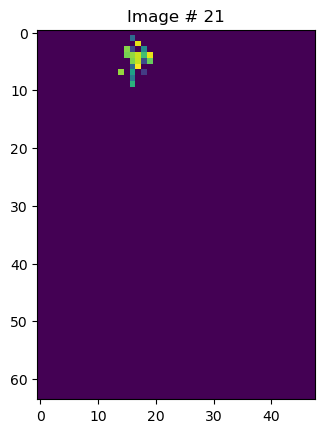

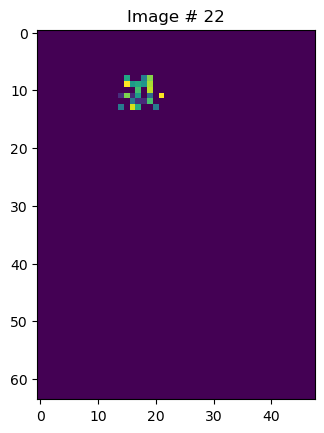

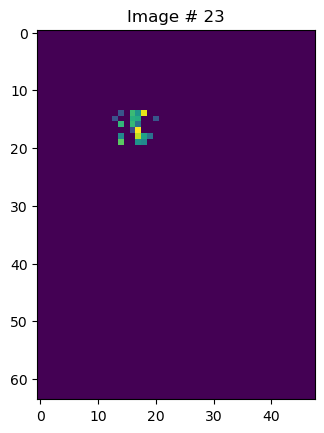

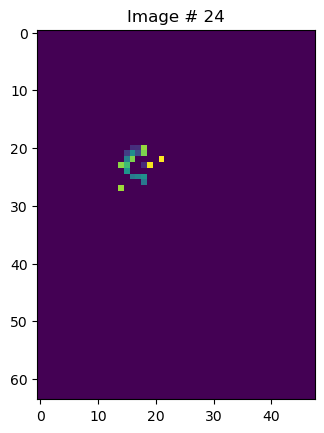

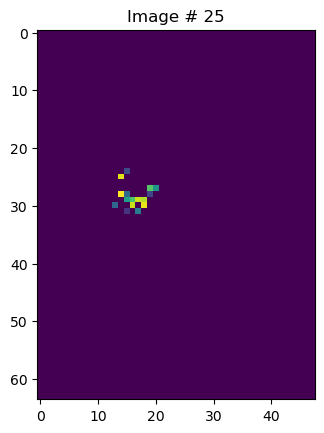

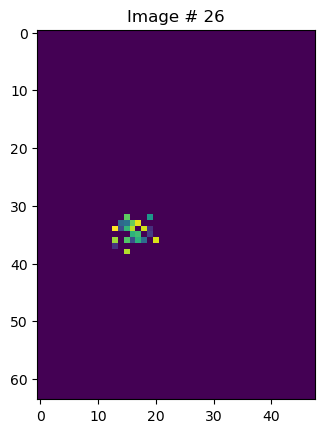

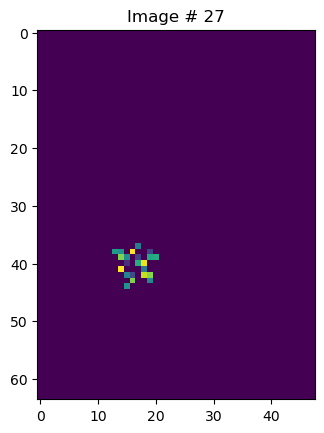

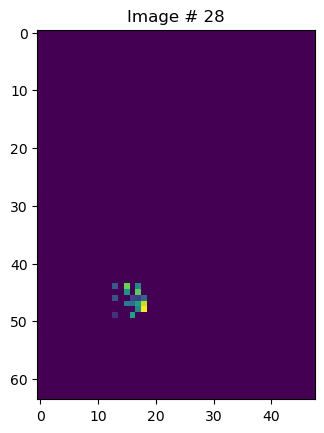

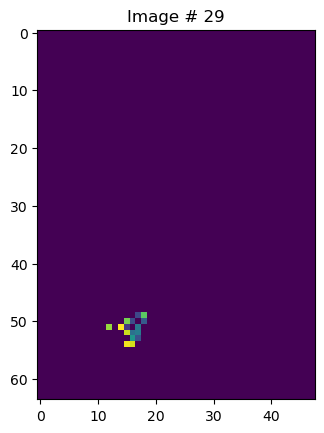

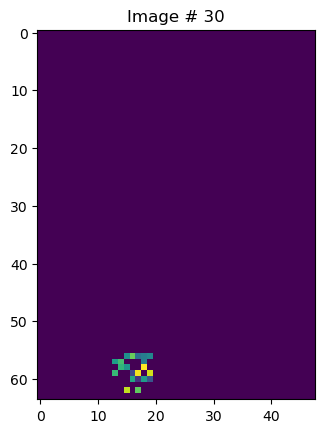

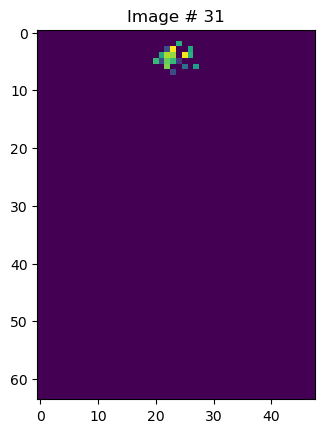

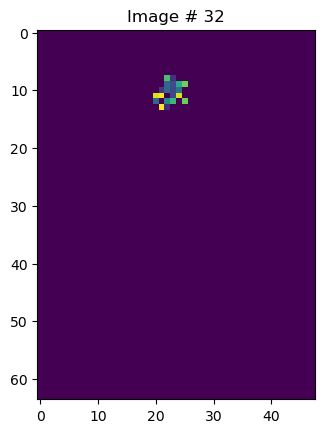

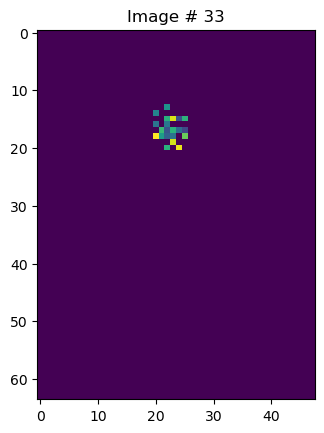

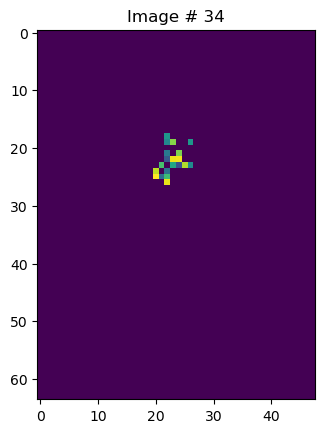

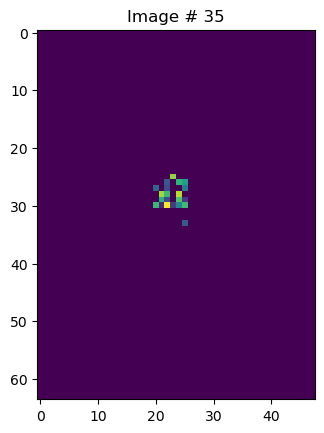

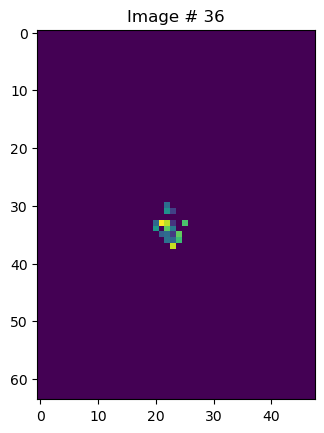

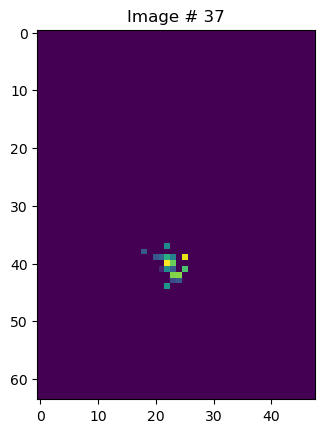

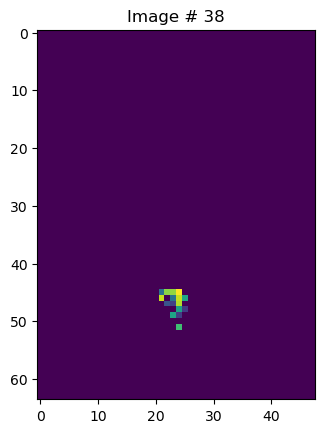

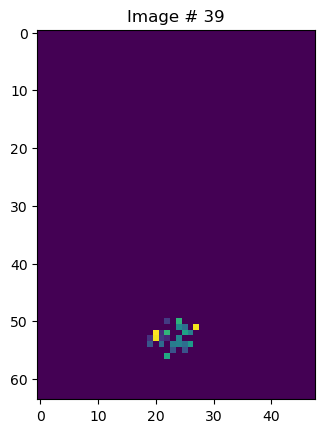

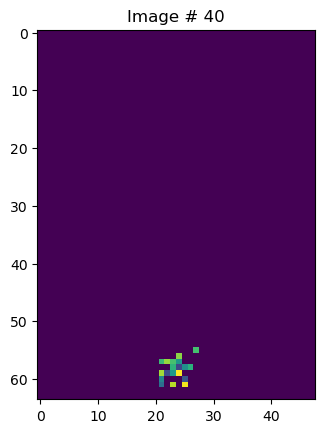

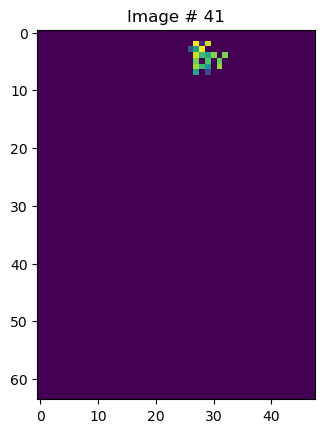

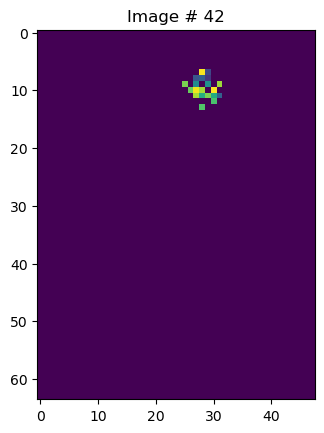

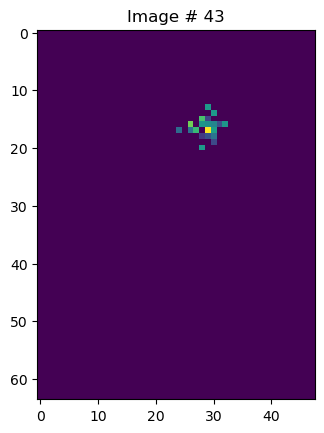

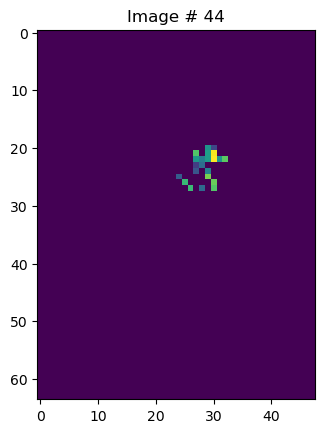

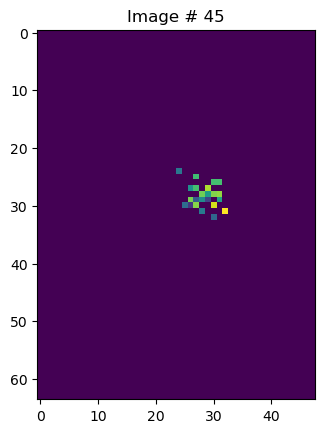

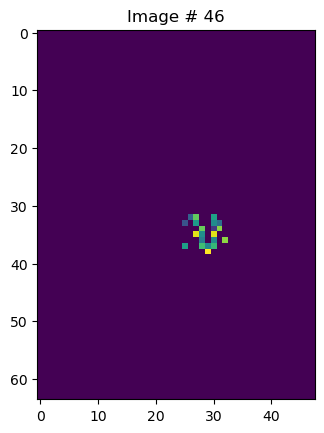

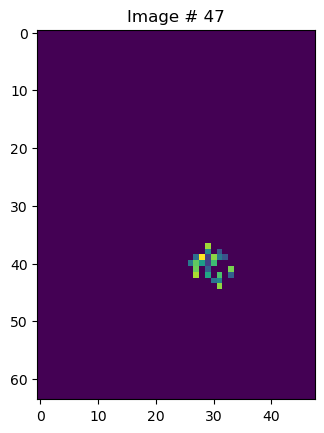

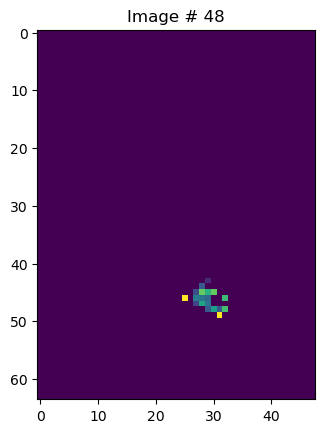

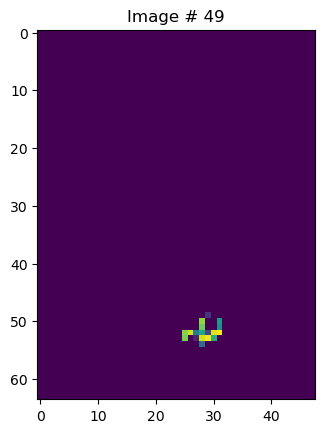

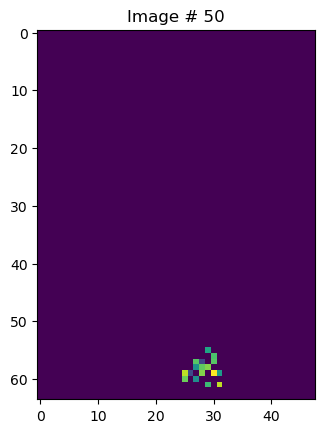

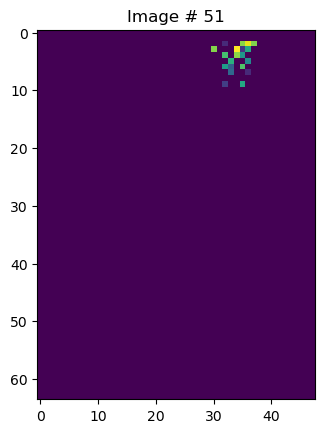

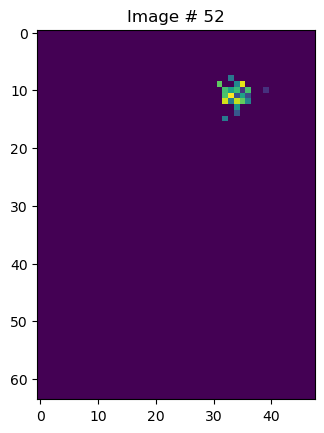

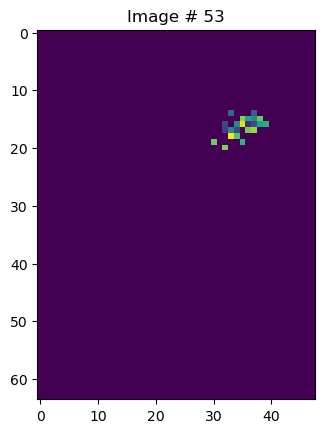

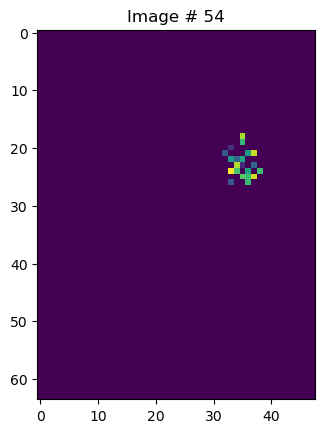

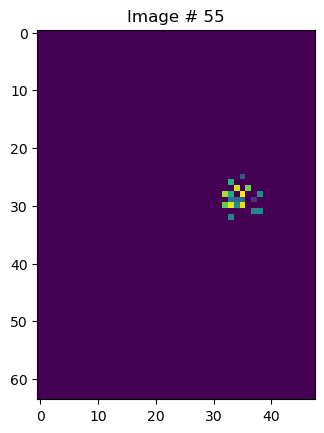

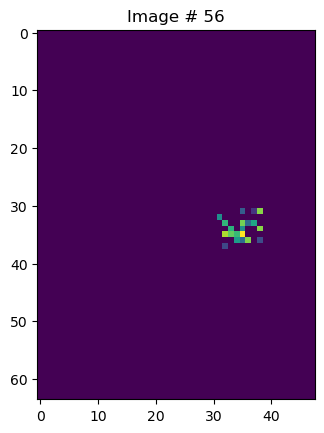

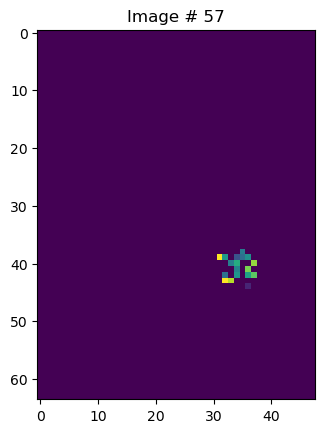

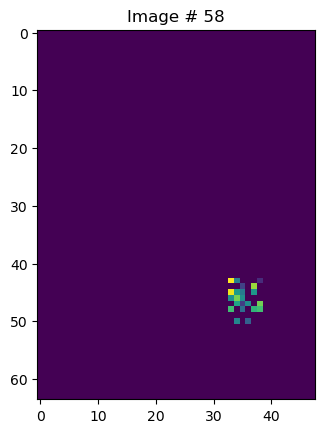

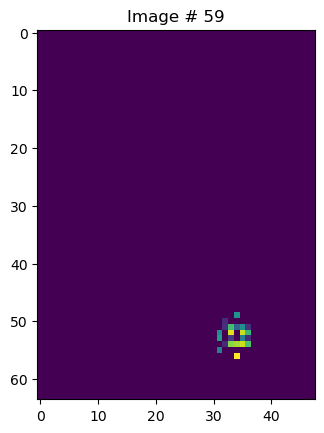

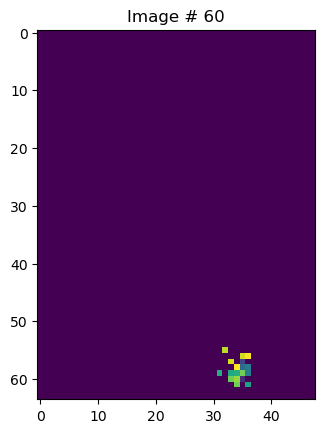

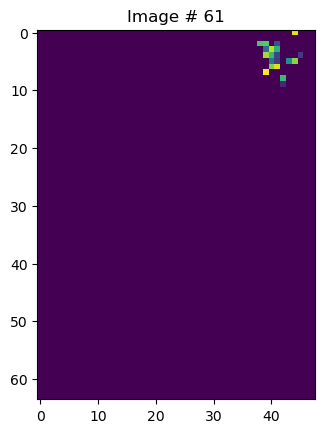

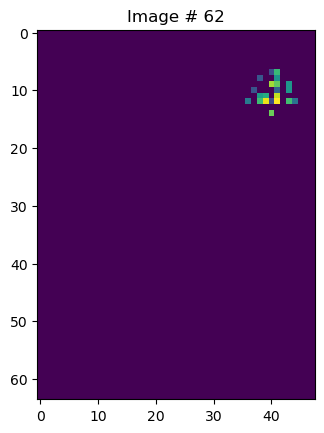

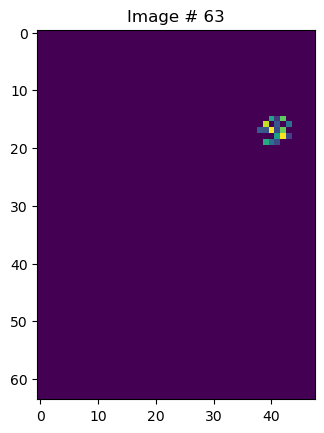

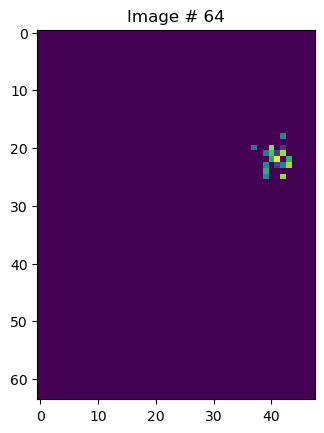

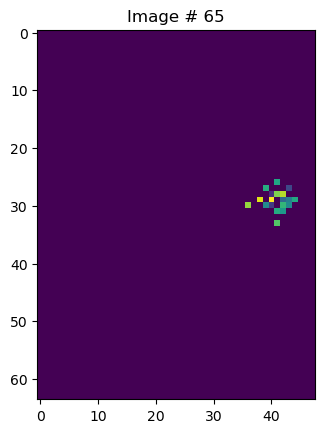

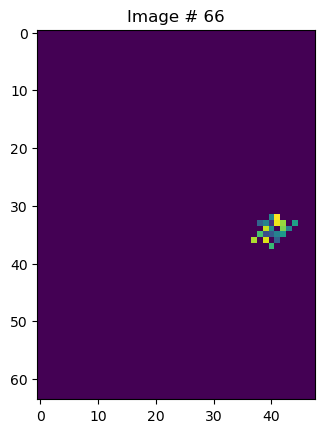

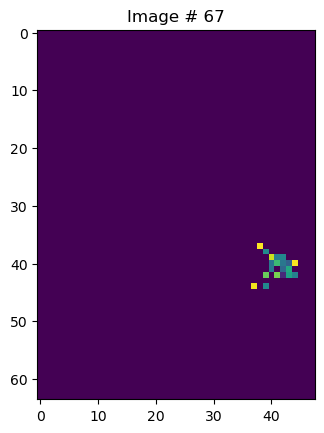

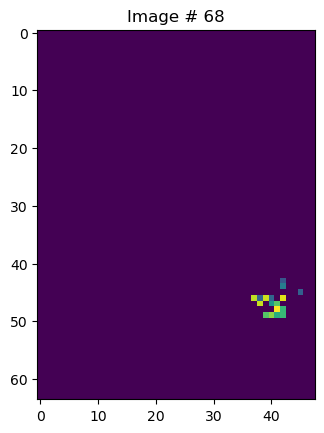

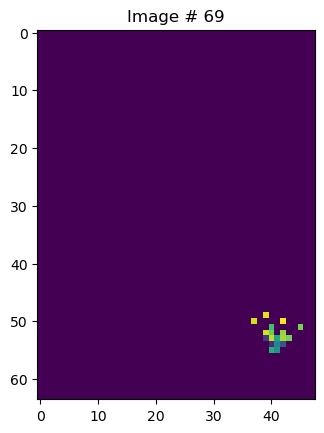

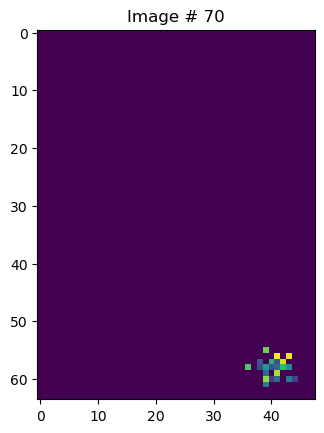

In [38]:
plt.figure()
plt.imshow(np.sum(rf_SA_array,axis=0).reshape(pixel_h, pixel_w), cmap='viridis')
plt.title('Total receptive field')
plt.show()


for i in range(len(rf_SA_array)):
    plt.figure()
    plt.imshow(rf_SA_array[i].reshape(pixel_h, pixel_w), cmap='viridis')
    plt.title('Image # {}'.format(i+1))
    plt.show()


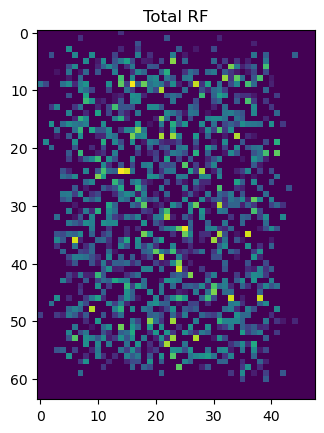

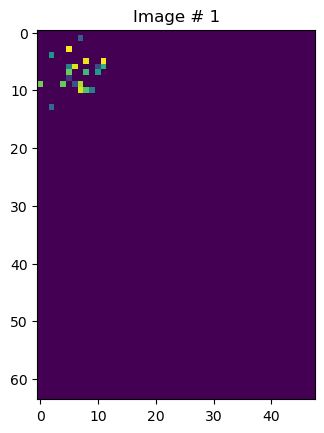

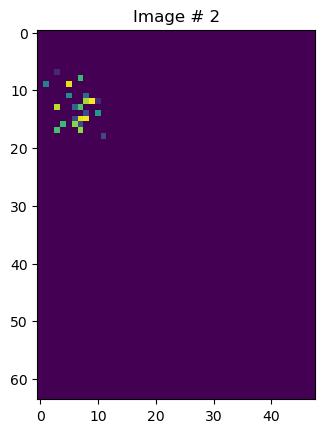

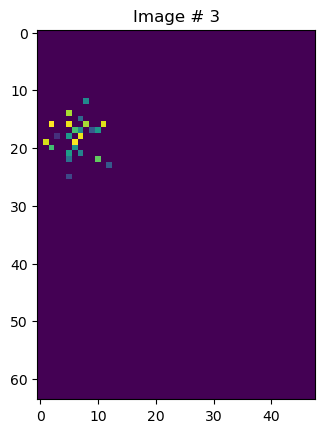

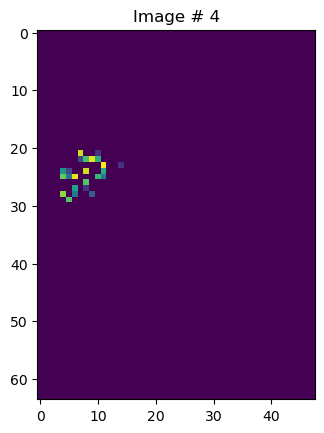

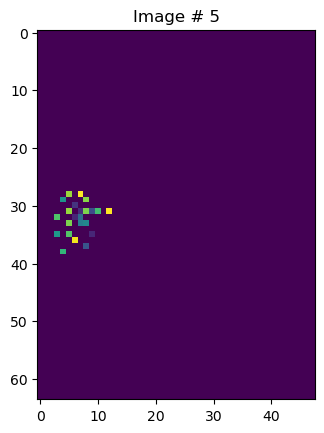

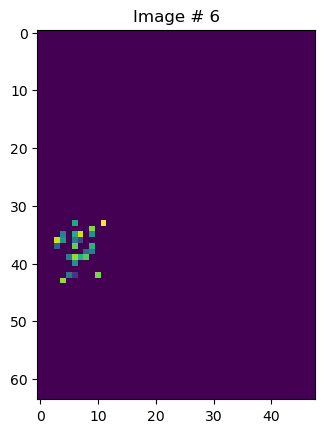

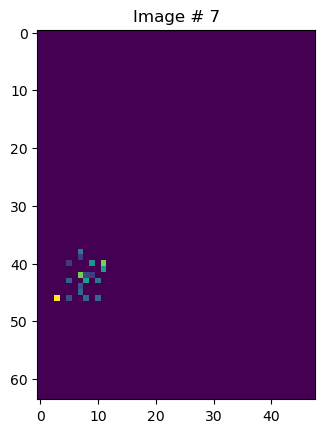

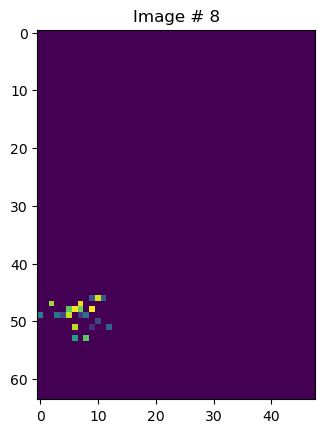

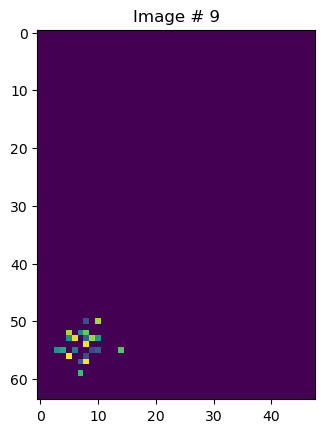

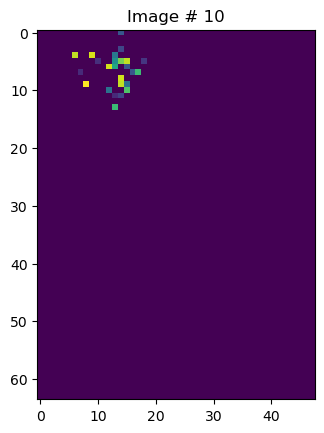

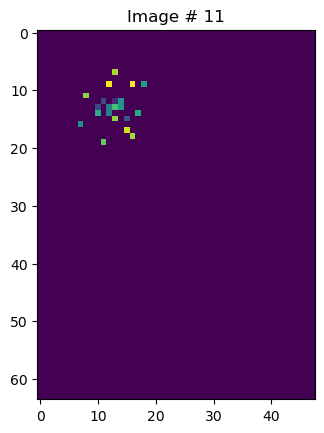

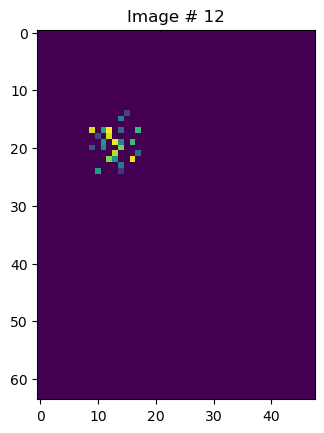

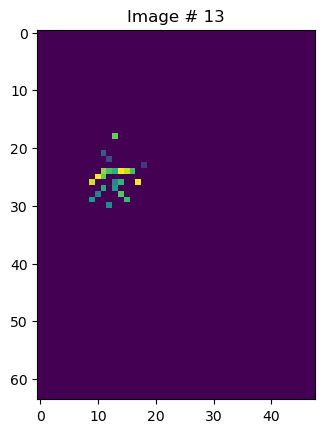

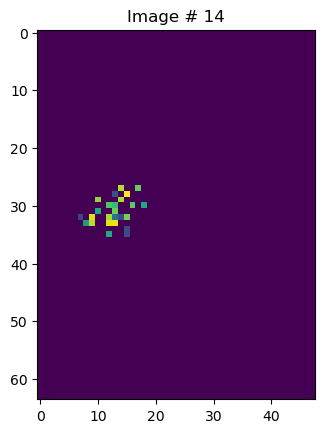

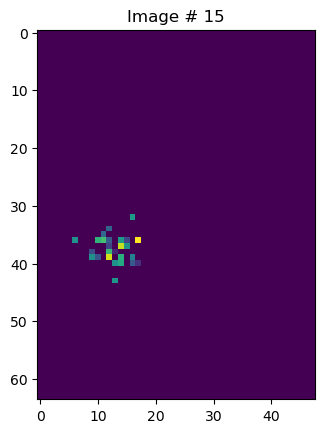

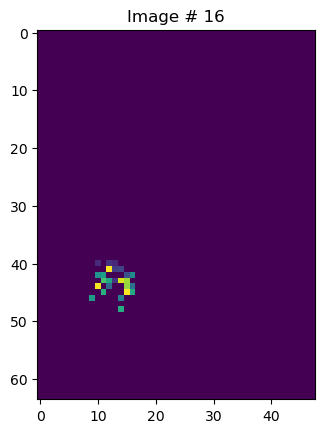

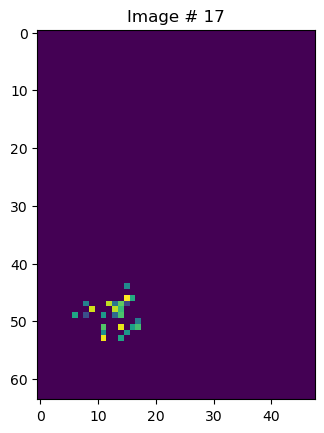

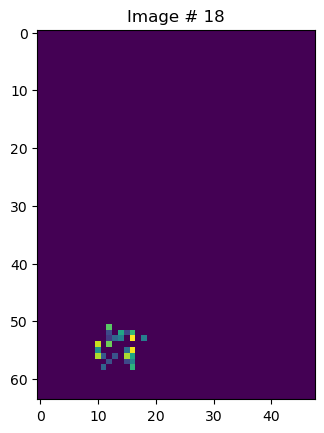

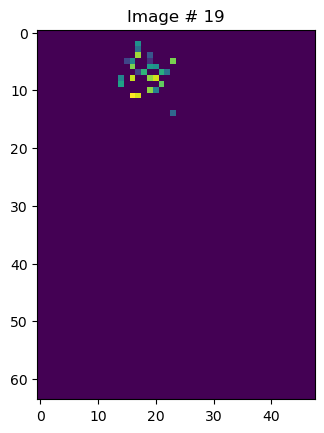

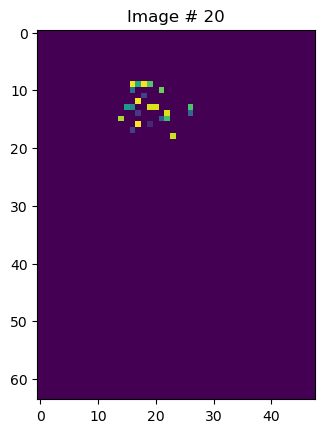

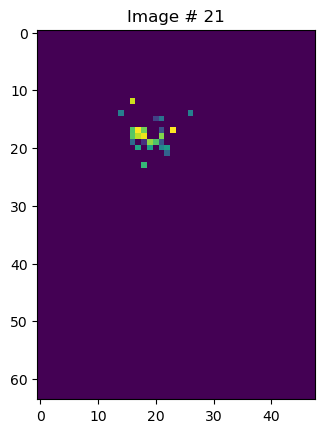

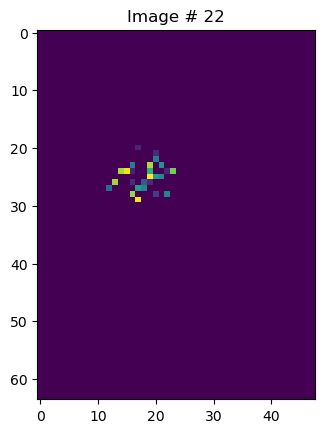

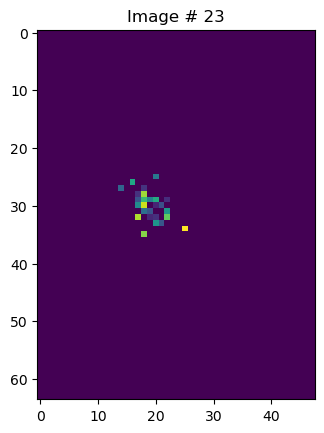

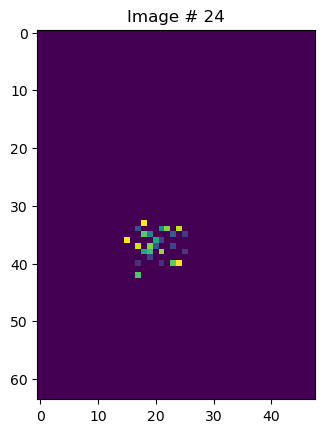

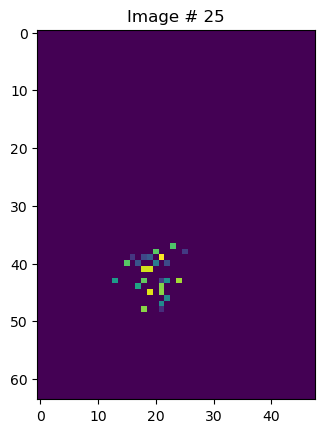

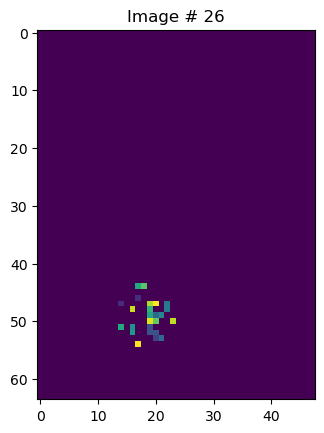

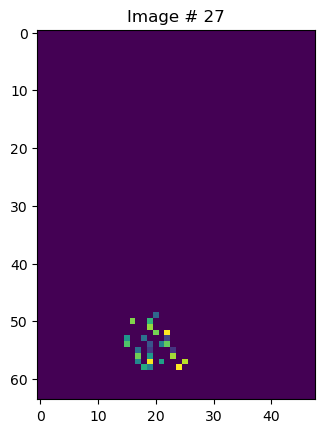

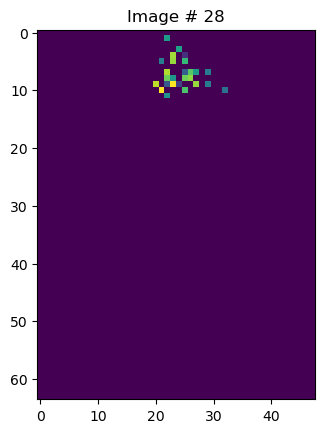

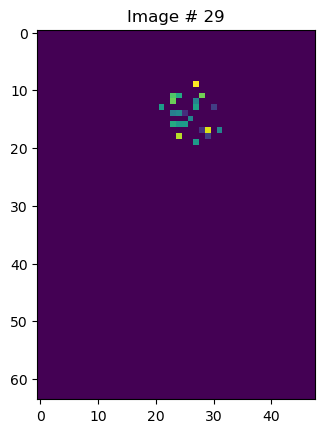

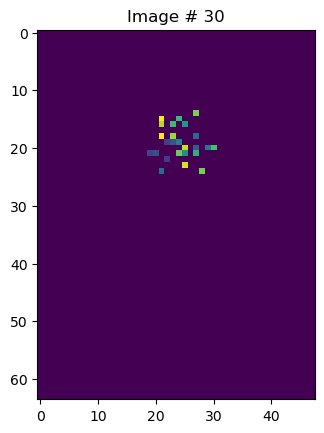

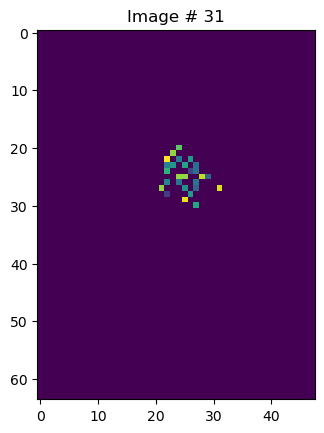

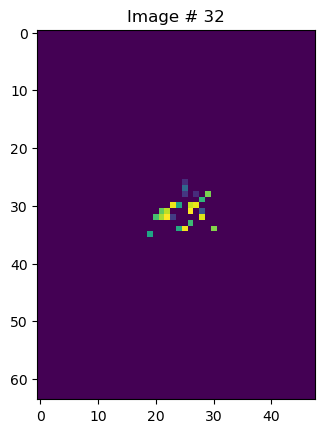

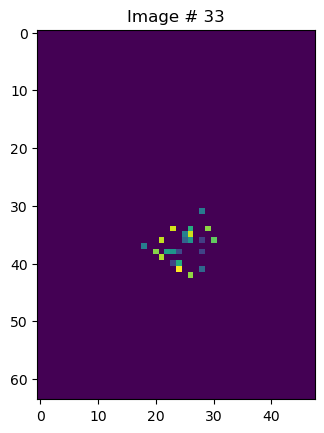

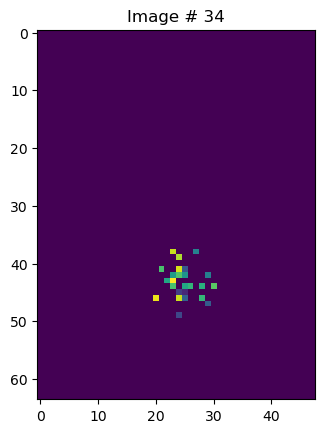

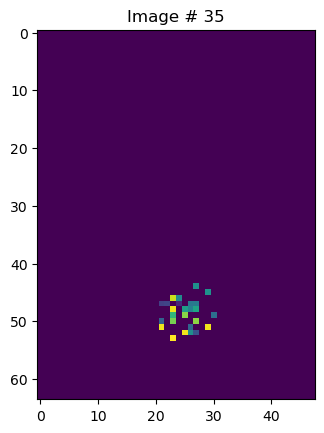

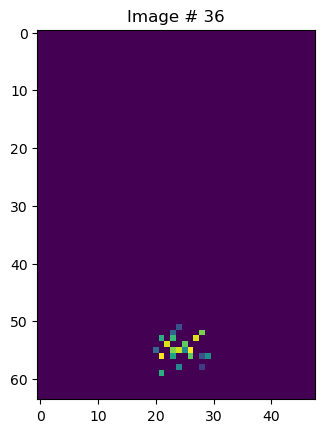

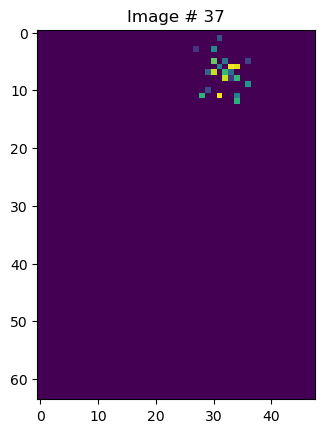

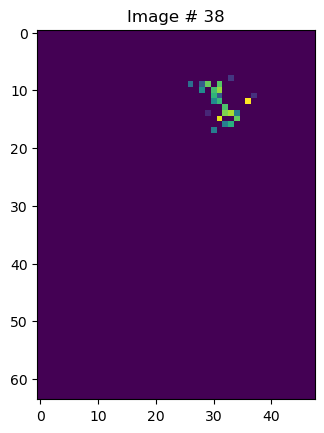

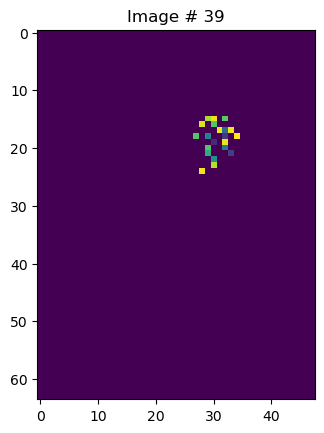

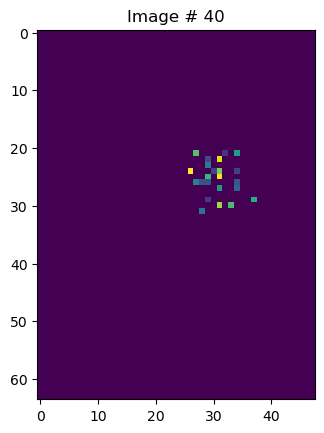

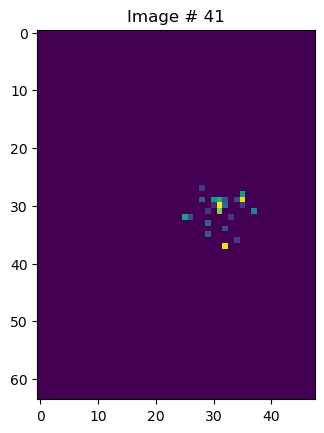

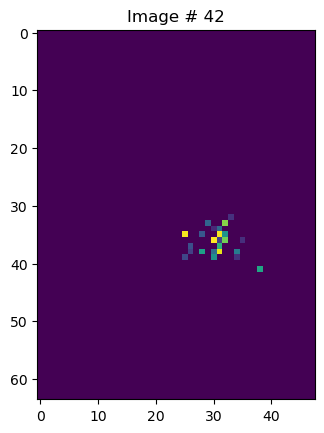

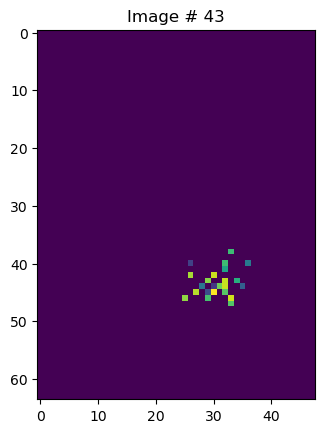

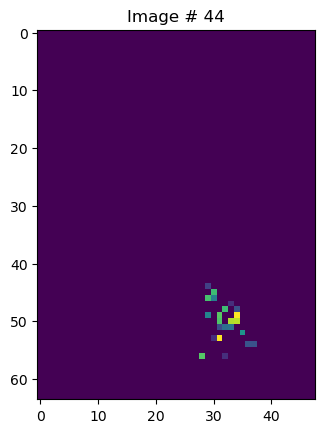

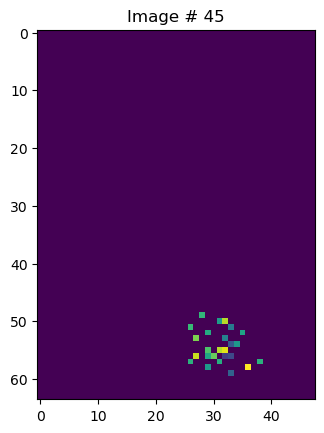

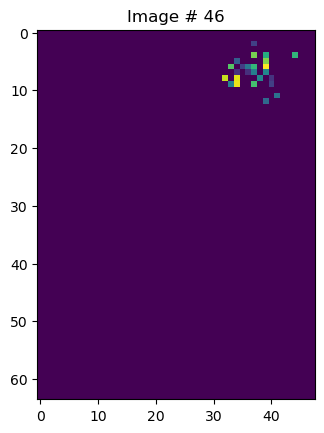

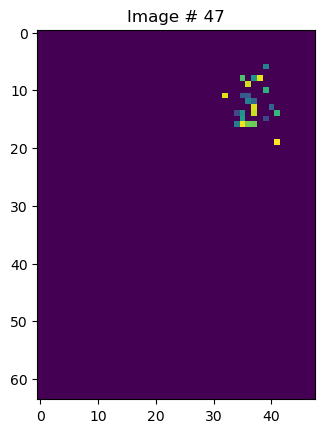

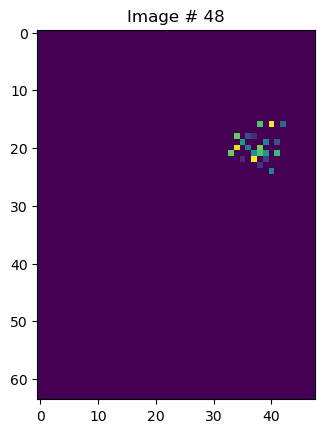

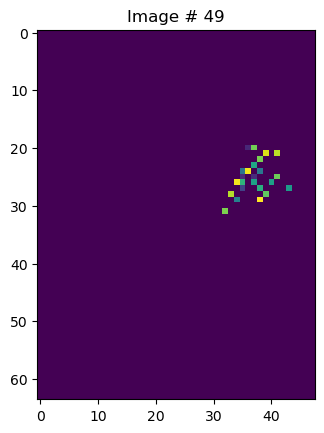

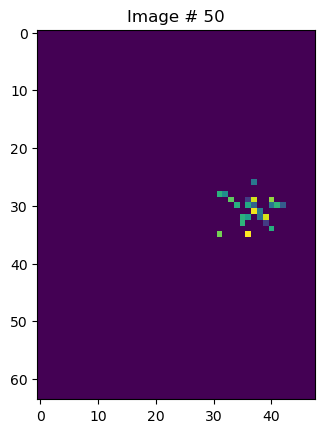

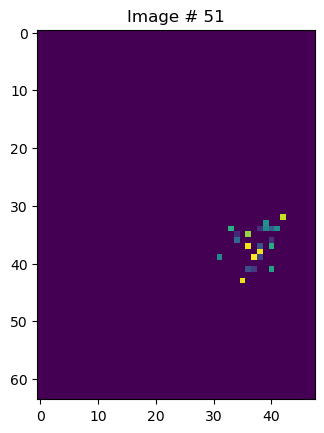

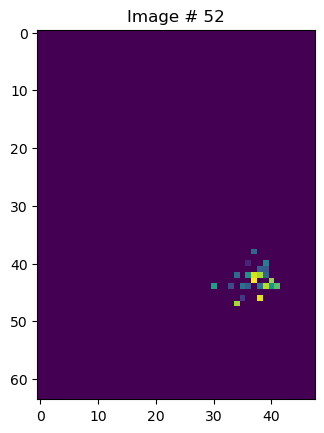

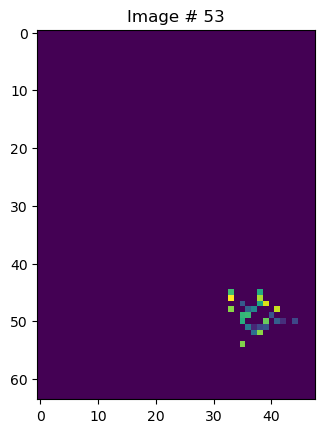

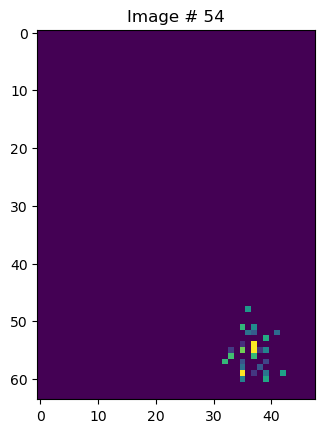

In [39]:
plt.figure()
plt.imshow(np.sum(rf_RA_array,axis=0).reshape(pixel_h, pixel_w), cmap='viridis')
plt.title('Total RF')
plt.show()

for i in range(len(rf_RA_array)):
    plt.figure()
    plt.imshow(rf_RA_array[i].reshape(pixel_h, pixel_w), cmap='viridis')
    plt.title('Image # {}'.format(i+1))
    plt.show()



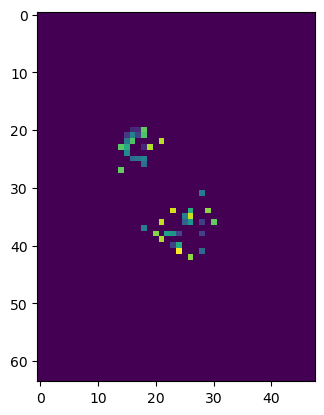

In [40]:
tmp_array = rf_SA_array[23] + rf_RA_array[32]


plt.figure()
plt.imshow(tmp_array.reshape(
    pixel_h, pixel_w), cmap='viridis')
plt.show()
